# Markov Word Generator from Scratch

As a starting point to understanding natural language processing and generation, I thought about text generation in a determinstic way, without machine learning, based on the exact words that follow from combination of words before in any given text. And the next words forms part of the combination that then generates the next word, and so on...

From my mathematical background, this showed Markov properties which led me to consider how to build a transition matrix from all of this. My exposure to Python and data science at the time was solely with numerical data in Numpy or Pandas and so I approached this problem from that perspective.

The first step is to load a corpus of text and clean the data, but preserving grammatical structure such that the Markov process will generate grammatically correct words at each step.

I have then created a function to break the text into phrases of any length and the following word/phrase. This essentially creates a dataframe of a feature and a label of 10s of thousands of rows depending on the initial length of the text.



In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
root_folder = '/content/drive/My Drive/WordGeneration'

In [6]:
data = pd.read_csv(root_folder+'/FOMC2021.txt', sep="\n")

In [7]:
data.rename(columns={"Action to Adopt Changes to the Committee's Rules Regarding Availability of Information": "text"},
          inplace=True)
data["text"] = data["text"].str.replace("United States", "US")
data["text"] = data["text"].str.replace("U.S.", "US")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    486 non-null    object
dtypes: object(1)
memory usage: 3.9+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [7]:
len_text = 3
len_result = 1

In [8]:
func_folder = '/content/drive/My Drive/Colab Notebooks'

In [9]:
import sys
sys.path.append(func_folder)

In [10]:
import Contractions
from Contractions import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
def clean(text):
    text = re.sub('[0-9]+.\t', '', str(text)) # removing paragraph numbers
    text = re.sub('U.S.', 'USA', str(text))
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(' ')])
    text = re.sub('\n ', '', str(text))
    text = re.sub('\n', ' ', str(text))
    text = re.sub("'s", '', str(text))
    text = re.sub("-", ' ', str(text))
    text = re.sub("— ", '', str(text))
    text = re.sub('\"', '', str(text))
    text = re.sub("Mr\.", 'Mr', str(text))
    text = re.sub("Mrs\.", 'Mrs', str(text))
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    text = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', text) # add space around punctuation, i.e. treat them as token
    text = re.sub(r'\s\s', ' ', text)

    return text

In [12]:
data['text_clean'] = data['text'].apply(clean)

In [13]:
def sequence_generator(texts,
                      training_length, 
                      result_length, 
                      max_train=100000,
                      start_end_tokens=False,
                      lower=True):

    tokenizer = Tokenizer(lower=lower)
    tokenizer.fit_on_texts(texts)

    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # import pickle
    # with open('tokenizer.pickle', 'wb') as handle:
    #     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    sequences = tokenizer.texts_to_sequences(texts)

    # Start-End tokens
    # x = word_idx["start_token"]
    # y = word_idx["end_token"]

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + result_length + 3)]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []
    training_seq_words = []
    labels_words = []

    for seq in new_sequences:

        if len(training_seq) < max_train:
            for i in range(training_length, len(seq) - result_length):
                # Extract the features and label
                extract = seq[i - training_length:i + result_length]
                training_seq.append(extract[:training_length])
                if start_end_tokens:
                    label_adj = [x] + extract[training_length:] + [y]
                else: label_adj = extract[training_length:]
                labels.append(label_adj)

                training_seq_words.append([idx_word[j] for j in extract[:training_length]])
                labels_words.append([idx_word[j] for j in extract[training_length:]])

    print(f'There are {len(training_seq)} training sequences.')

    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels, \
           training_seq_words, labels_words

In [14]:
word_idx, idx_word, num_words, word_counts, new_texts, sequences, features, labels, training_seq_words, labels_words = \
    sequence_generator(
    data['text_clean'].tolist(), training_length = len_text, result_length = len_result, lower=True)

There are 2954 unique words.
There are 55802 training sequences.


In [15]:
df = pd.DataFrame({'features': training_seq_words, 'labels': labels_words})

In [16]:
df['labels'] = df['labels'].map(lambda x: x[0])

In [17]:
df

,features,labels
0,"[by, unanimous, vote]",the
1,"[unanimous, vote, the]",committee
2,"[vote, the, committee]",approved
3,"[the, committee, approved]",a
4,"[committee, approved, a]",final
...,...,...
55797,"[pressures, and, inflation]",expectations
55798,"[and, inflation, expectations]",and
55799,"[inflation, expectations, and]",financial
55800,"[expectations, and, financial]",and


## Creating the Transition Matrix

The following can be made more Pythonic but it was intuitive to set out each change step by step. First, one-hot encoding is done of the labels to create a dataframe with columns equal to the number of unique vocabulary.

Secondly, groupby operation is used on the features phrase (in this case a three word phrase) to group by number of instances of each phrase and a count of the word that follows.

Dividing each row by the total of that row creates a probability distribution of the word that follows the three word phrase corresponding to that row. This is our transition matrix.

In [21]:
markov_matrix = pd.concat([df, pd.get_dummies(df['labels'])], axis=1)

In [22]:
markov_matrix = markov_matrix.drop(['labels'], axis=1)

In [26]:
markov_matrix['features'] = markov_matrix['features'].apply(" ".join)

In [48]:
transition_matrix = markov_matrix.groupby('features',as_index=False)[markov_matrix.columns.tolist()].sum()

In [53]:
# transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

In [49]:
phrase_dict = transition_matrix['features'].to_dict()
word_dict = dict(enumerate(transition_matrix.columns.tolist()))

In [54]:
phrase_dict_reversed = {v: k for k, v in phrase_dict.items()}

In [33]:
from scipy import sparse

In [ ]:
pd.DataFrame.sparse.to_coo(transition_matrix)
transition_matrix = sparse.csr_matrix(transition_matrix.to_coo())

## Generating Words

To use our transition matrix, we create dictionaries of the phrases and its index as well as the vocabulary and its index in the transition matrix. Given a phrase, the index of the row is located and the np.random.choice generates the following word weighted by the probabilities in that row. The other function then appends the word to our generated sentence and extracts the last three-word-phrase to loop through the process as many times as defined.

In [37]:
def add_weights_temperature(input_weights, temperature):
    weights = np.where(input_weights == 0, 0, np.log(input_weights + 1e-10)) / temperature
    weights = np.exp(weights)
    return weights / np.sum(weights)

In [138]:
def return_next_word(prefix, temperature=1):
    prefix_ind = phrase_dict_reversed[prefix]
    weights = transition_matrix.iloc[prefix_ind].values[1:].astype('float64')
    prob = weights / sum(weights)
    if temperature != 1:
        weights = add_weights_temperature(prob, temperature)

    token_ind = np.random.choice(range(len(weights)), p=prob)+1
    next_word = word_dict[token_ind]
    return next_word

In [147]:
def generate_words(seed, length):
    next_word = return_next_word(seed)
    sentence = seed.split()
    
    for i in range(length):
        sentence.append(next_word)
        next_word = return_next_word(" ".join(sentence[-3:]))
    
    return " ".join(sentence)

In [149]:
generate_words("accumulated by households", 100)

"accumulated by households since the beginning of the period to negotiations on the debt limit by 480 billion market participants' estimates of the new date when the treasury would exhaust its extraordinary measures and cash balance were wide ranging but some estimates suggested the date might be as early as mid december most market participants anticipated adjustments to the pace of purchases if warranted by changes in the composition of the federal reserve bank of new york until instructed otherwise to execute transactions in the soma in accordance with the committee assessments of maximum employment and inflation and posed considerable risks to the"

In [150]:
generate_words("early as mid", 100)

'early as mid december most market participants anticipated that the economy were to evolve broadly as they anticipated they judged that the release of pent up demand could boost consumption growth further as social distancing restrictions were imposed to rein in a new wave of covid 19 in the us amid this progress and strong policy support indicators of economic activity and employment had continued to surge and expected that it would likely be appropriate in each subsequent month some participants preferred a somewhat faster pace of reductions that would result in reducing the monthly pace of the recovery indicators of economic activity'

In [ ]:
def create_transition_matrix(self):
    row_ind, col_ind, values = [], [], []

    for i in range(len(self.tokens[:-self.n])):
        ngram = ' '.join(self.tokens[i:i + self.n])
        ngram_ind = self.ngram2ind[ngram]
        next_word_ind = self.token2ind[self.tokens[i + self.n]]

        row_ind.extend([ngram_ind])
        col_ind.extend([next_word_ind])
        values.extend([1])

    S = scipy.sparse.coo_matrix((values, (row_ind, col_ind)), shape=(len(self.ngram2ind), len(self.token2ind)))
    return S

# LSTM Deep Learning Model

Moving on into Deep Learning, we approach this from the perspective of a many-to-one sequence problem. In much of the same way, we generate our features sequences and labels as numpy arrays. We then also one-hot encode the features.

The next step is where the earlier-completed tokenization comes into play as we also need to create an embedding for the words. In essence, an embedding is a vector representation of words and their relative distance to other words. There are existing embeddings such as GloVe which have been trained a much larger datasets and can be imported. Otherwise, we can train our own embedding.

In [14]:
len_text = 30
len_result = 1

In [15]:
word_idx, idx_word, num_words, word_counts, new_texts, sequences, features, labels, training_seq_words, labels_words = \
    sequence_generator(
    data['text_clean'].tolist(), training_length = len_text, result_length = len_result, lower=True)

There are 2953 unique words.
There are 43934 training sequences.


In [16]:
TRAIN_FRACTION = 0.7
RANDOM_STATE = 50

In [17]:
from sklearn.utils import shuffle

In [18]:
def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):

    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # numpy array with one-hot encoding consisting of number of training data 
    # and size of vocabulary with 1 at the corresponding word following from the features
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    return X_train, X_valid, y_train, y_valid

In [19]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)

## Pre-trained Embedding with GloVe (Optional)

In [ ]:
glove = np.loadtxt('glove.6B.100d.txt', dtype='str', comments=None, encoding="utf8")
print(glove.shape)
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]
del glove

In [ ]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}
embedding_matrix = np.zeros((num_words, vectors.shape[1]))

In [ ]:
not_found = 0

In [ ]:
for i, word in enumerate(word_idx.keys()):
    vector = word_lookup.get(word, None)

    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

In [ ]:
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

In [ ]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n=10):

    idx = word_idx.get(query, None)
    if idx is None:
        print(f'{query} not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        if np.all(vec == 0):
            print(f'{query} has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)

            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]

    print(f'Query: {query}\n')
    max_len = max([len(i) for i in closest])
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

## Building and Training LSTM Model

Whether or not we have the pre-trained embeddings, we approach this problem based on the sequence of words, which is however long we specify and earch further represented by the dimensions of the embedding.

We can train a recurrent neural network with one or several layers on these token sequences with embeddings to predict the label, i.e. the token/word that follows.

In [20]:
LSTM_CELLS = 64
embedding_dim = 200
EPOCHS = 20
BATCH_SIZE = 2048
VERBOSE = 0

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional

In [43]:
model = Sequential()

In [44]:
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, trainable=True))

In [ ]:
model.add(LSTM(LSTM_CELLS, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

In [ ]:
model.add(LSTM(LSTM_CELLS, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

In [ ]:
model.add(Bidirectional(LSTM(LSTM_CELLS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))

In [48]:
model.add(Dense(num_words, activation='softmax'))

In [49]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         590600    
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          67840     
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          33024     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 2953)              380937    
                                                                 
Total params: 1,138,449
Trainable params: 1,138,449
Non-trainable params: 0
____________________________________________

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [51]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    validation_data=(X_valid, y_valid))

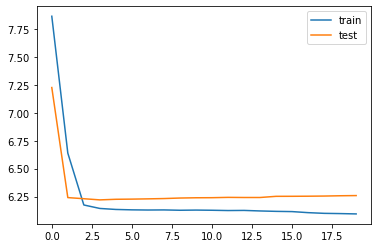

In [31]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.save(root_folder+'/BiLSTMNLG', save_format='tf')

In [56]:
import tensorflow as tf

In [ ]:
load_model = Sequential()
load_model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, trainable=True))
load_model.add(LSTM(LSTM_CELLS, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
load_model.add(LSTM(LSTM_CELLS, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
load_model.add(Bidirectional(LSTM(LSTM_CELLS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
load_model.add(Dense(num_words, activation='softmax'))
load_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
load_model.load_weights(root_folder+'/BiLSTMNLG')

In [63]:
history = load_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    validation_data=(X_valid, y_valid))

In [64]:
r = load_model.evaluate(X_valid, y_valid, batch_size=2048, verbose=1)

7/7 [==============================] - 1s 116ms/step - loss: 6.1994 - accuracy: 0.0676


In [69]:
import random

In [78]:
def generate_output(model,
                    sequences,
                    training_length=len_text,
                    new_words=50,
                    diversity=1,
                    return_output=False,
                    n_gen=1):

    seq = random.choice(sequences)
    seed_idx = random.randint(0, len(seq) - training_length - 10)
    end_idx = seed_idx + training_length

    gen_list = []

    for n in range(n_gen):
        # Extract the seed sequence
        seed = seq[seed_idx:end_idx]
        original_sequence = [idx_word[i] for i in seed]
        generated = seed[:] + ['#']

        actual = generated[:] + seq[end_idx:end_idx + new_words]

        for i in range(new_words):

            preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(
                np.float64)

            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)

            # Softmax
            preds = exp_preds / sum(exp_preds)

            # Choose the next word
            probas = np.random.multinomial(1, preds, 1)[0]

            next_idx = np.argmax(probas)

            # New seed adds on old word
            seed = seed[1:] + [next_idx]
            generated.append(next_idx)

        # Showing generated and actual abstract
        n = []

        for i in generated:
            n.append(idx_word.get(i, '< --- >'))

        gen_list.append(n)

    a = []

    for i in actual:
        a.append(idx_word.get(i, '< --- >'))

    a = a[training_length:]

    gen_list = [
        gen[training_length:training_length + len(a)] for gen in gen_list
    ]

    return ' '.join(original_sequence), ' '.join(gen_list[0]), ' '.join(a)

In [79]:
generate_output(load_model, sequences)

('remained accommodative consumer credit jumped in may and remained strong in june reflecting a rebound in credit card balances and continued robust growth in auto loans banks in the july',
 '< --- > inflation distribution rate reviewed time firms low treasury recovery chinese in the to market winding adaptation net weigh',
 '< --- > sloos reported stronger demand and easier standards for both credit cards and auto loans over the second quarter')

# With GPT2

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_path,
    block_size=128)
     
test_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=test_path,
    block_size=128)

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
training_args = TrainingArguments(
    output_dir = 'data/out', # the output directory for the model predictions and checkpoints
    overwrite_output_dir = True, # overwrite the content of the output directory
    per_device_train_batch_size = 32, # the batch size for training
    per_device_eval_batch_size = 32, # the batch size for evaluation
    learning_rate = 5e-5, # defaults to 5e-5
    num_train_epochs = 3, # total number of training epochs to perform
)
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator=data_collator,
    train_dataset = train_dataset,
    eval_dataset = test_dataset
)

trainer.train()